<a href="https://colab.research.google.com/github/AnnieCRY/DS5230-project/blob/master/hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [683]:
%%capture
!wget -nc https://raw.githubusercontent.com/AnnieCRY/DS5230-project/master/relabel.py
import relabel

In [684]:
# download the supporting files from github
! rm -rf Audio_based_identification_beehive_states/
! git clone https://github.com/Tonyz4516/Audio_based_identification_beehive_states.git

! mv Audio_based_identification_beehive_states/Bee_NotBee_classification/* ./

Cloning into 'Audio_based_identification_beehive_states'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (118/118), 69.02 KiB | 4.06 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [685]:
%%capture
! pip install muda

In [686]:
# move zip file to colab vm
! cp -r gdrive/My\ Drive/5230Project/processed_data_25_1.zip ./

cp: cannot open 'gdrive/My Drive/5230Project/processed_data/state_labels.gsheet' for reading: Operation not supported


In [688]:
import os
import matplotlib.pyplot as plt
from utils import *
import scipy
import sklearn, librosa, mir_eval, IPython.display, urllib
import pandas as pd
import numpy as np

In [ ]:
! unzip processed_data_25_1.zip

In [689]:
def modify_labels(path_workingFolder):
    csv_file = path_workingFolder+"labels_BeeNotBee_th0.csv"
    labels_BeeNotBee_th0 = pd.read_csv(csv_file)

    def add_new_labels(df):
        labels_l=[]
        for x in df['label_strength']:
            if x>0.95:
                labels_l.append('nobee') 
            elif x==0:
                labels_l.append('bee') 
            else:
                labels_l.append('unknown') 
        df['label']=labels_l
        return df,labels_l,df['sample_name']
    
    labels_BeeNotBee_th0,labels,ids=add_new_labels(labels_BeeNotBee_th0)
    labels_BeeNotBee_th0.to_csv(csv_file)
    return labels,ids
path_workingFolder = '/content/processed_data_25_1/'
labels,ids=modify_labels(path_workingFolder)

In [690]:
block_size = 5
# path where to save audio segments and labels files.
labels2read = 'labels_BeeNotBee_th0'
feature = 'MFCCs20'

sample_ids=[]
for id in ids:
    sample_ids.append(id+'.wav')

In [693]:
X_train = get_features_from_samples(path_workingFolder, sample_ids, 'MFCCs20', 'NO', 1)
# X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 1)
# X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 1)

In [694]:
# debug
test = pd.read_csv(path_workingFolder+"labels_BeeNotBee_th0.csv")
test.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sample_name,segment_start,segment_finish,label_strength,label
0,0,0,0,CF003 - Active - Day - (225)__segment0,0,5,0.0,bee
1,1,1,1,CF003 - Active - Day - (225)__segment1,5,10,0.0,bee
2,2,2,2,CF003 - Active - Day - (225)__segment2,10,15,0.0,bee
3,3,3,3,CF003 - Active - Day - (225)__segment3,15,20,0.0,bee
4,4,4,4,CF003 - Active - Day - (225)__segment4,20,25,0.0,bee


In [695]:
def get_GT_labels_fromFiles(path_labels, sample_ids, labels2read) : #labels2read =  name of the label file
    labels = []
    fileAsdict={}
    
    with open(path_labels + labels2read+'.csv', 'r') as labfile:
        csvreader = csv.reader(labfile, delimiter=',')    
        for row in csvreader:
            if not row[3] == 'sample_name':
                fileAsdict[row[3]]=row[-1]   # row[-1] = '/missing queen/active' or 'bee/nobee'
                 
    for sample in sample_ids:
        labels.append(fileAsdict[sample[0:-4]])  #remove .wav extension

    return labels 

In [697]:
labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids, labels2read)
Y_train = labels_train

In [ ]:
# labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
# Y_train= labels2binary('nobee', labels_train)
    
# labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
# Y_val= labels2binary('nobee', labels_val)
    
# labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
# Y_test= labels2binary('nobee', labels_test)

In [700]:
# remove unknown label
new_X, new_Y = [], []
for i in range(len(Y_train)):
    if Y_train[i] == "bee":
        new_X.append(X_train[i])
        new_Y.append(1)
    elif Y_train[i] == "nobee":
        new_X.append(X_train[i])
        new_Y.append(0)

In [703]:
len(new_Y)/len(Y_train)

0.7966041740360806

### hierchical clustering

In [710]:
df_train = pd.DataFrame(data=new_X)

In [711]:
from sklearn.preprocessing import normalize
train_scaled = normalize(df_train)
train_scaled = pd.DataFrame(train_scaled, columns=df_train.columns)
# train_scaled.head()

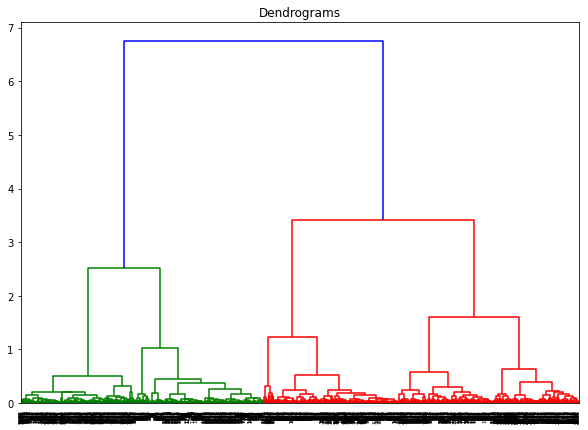

In [712]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7)) 
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(train_scaled, method='ward'))

In [713]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
Y_pred = cluster.fit_predict(train_scaled)

In [714]:
# PCA
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

In [715]:
pca = PCA(n_components = 2).fit_transform(train_scaled)
pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])
# 3 or 2 components
# pca = PCA(n_components = 3).fit_transform(train_scaled)
# pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2', 'PC3'])

In [716]:
# true label
pca_df1 = pd.concat([pca_df, pd.DataFrame(new_Y, columns = ['label'])], axis = 1)
fig = px.scatter(pca_df1, x='PC1', y='PC2',color='label')
fig.show()

In [717]:
# # true label
# pca_df1 = pd.concat([pca_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)
# fig = px.scatter_3d(pca_df1, x='PC1', y='PC2', z='PC3',color='label')
# fig.show()

In [718]:
# prediction
pca_df2 = pd.concat([pca_df, pd.DataFrame(Y_pred, columns = ['label'])], axis = 1)
fig2 = px.scatter(pca_df2, x='PC1', y='PC2',color='label')
fig2.show()

In [719]:
# # prediction
# pca_df2 = pd.concat([pca_df, pd.DataFrame(Y_pred, columns = ['label'])], axis = 1)
# fig2 = px.scatter_3d(pca_df2, x='PC1', y='PC2', z='PC3',color='label')
# fig2.show()

In [682]:
pca0 = PCA(n_components = 2).fit_transform(train_scaled)
pca0_df = pd.DataFrame(data = pca0, columns = ['PC1', 'PC2'])

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### evaluate

In [ ]:
Y_relab = list()
for l in Y_train:
    if l == "unknown":
        Y_relab.append(0)
    elif l == "bee":
        Y_relab.append(1)
    else:
        Y_relab.append(2)

In [ ]:
# confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(Y_relab, Y_pred)
# cm_df = pd.DataFrame(cm, 
#             columns = ['Predicted Negative', 'Predicted Positive'],
#             index = ['Actual Negative', 'Actual Positive'])
# cm_df
cm

array([[21,  5, 12],
       [29, 39, 31],
       [ 7, 11,  6]])

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
precision_score(Y_relab, Y_pred, average='weighted')

0.541234630498162

In [ ]:
recall_score(Y_relab, Y_pred, average='weighted')

0.40993788819875776

In [ ]:
f1_score(Y_relab, Y_pred, average='weighted')

0.440298525604405

In [ ]:
# precision recall curve only support binary

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from inspect import signature
precision, recall, threshold = precision_recall_curve(Y_relab, Y_pred)
average_precision = average_precision_score(Y_relab, Y_pred)
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='r', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

ValueError: ignored